In [3]:
from sklearn.datasets import fetch_openml
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans
import joblib
import os


# Load in the data 

In [70]:
mnist = fetch_openml('mnist_784')
X = mnist.data
y = mnist.target

/Users/shawheennaderi/Library/Python/3.9/lib/python/site-packages/sklearn/datasets/_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [71]:
# Reshape the data to a 28x28 image
image_index = 3  # You can change this index to display different images
image = X.iloc[image_index].to_numpy().reshape(28, 28)



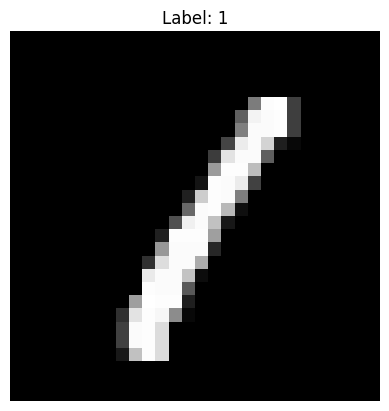

In [72]:
# Display the image
plt.imshow(image, cmap='gray')
plt.title(f'Label: {y[image_index]}')
plt.axis('off')  # Hide the axes
plt.show()

In [73]:
X = X.values.reshape(-1, 28, 28)  # Make sure X is reshaped into 28x28 images


In [78]:
# Define the function to extract 5x5 patches
def extract_patches(images, patch_size=5):
    patches = []
    for image in images:
        for i in range(image.shape[0] - patch_size + 1):
            for j in range(image.shape[1] - patch_size + 1):
                patch = image[i:i + patch_size, j:j + patch_size]
                if np.sum(patch) > 0:  # Filter out all-zero patches
                    patches.append(patch.flatten())
    return np.array(patches)



In [84]:
# Sample 10% of the images
X_sample = X[np.random.choice(len(X), size = int(len(X) * 0.1), replace =False)]

In [85]:

# Extract patches
patches = extract_patches(X_sample)

# Check what the patches look like 

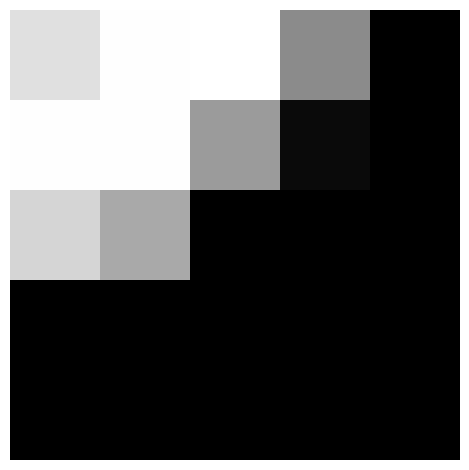

In [100]:
i = 7000

fig, ax = plt.subplots()
patch = patches[i].reshape(5,5)
ax.imshow(patch, cmap ='gray', interpolation = 'nearest')
ax.axis('off')
plt.tight_layout()
plt.show()

### Save patches  

In [101]:
np.save('mnist_patches.npy', patches)

In [4]:
patches = np.load('mnist_patches.npy')
norms = np.linalg.norm(patches, axis = 1, keepdims= True) #compute the norm 
patches = patches / norms #normalize the patches 


In [103]:
def save_models(models, directory='models'):
    import os
    if not os.path.exists(directory):
        os.makedirs(directory)
    for k, model in models.items():
        filename = os.path.join(directory, f'kmeans_{k}.pkl')
        joblib.dump(model, filename)

In [61]:
def perform_kmeans_clustering(data, k_values, batch_size=6, max_iter=10, n_init="auto", verbose=True):
    models = {}
    for k in k_values:
        if verbose:
            print(f"Clustering with k = {k}...")
        try:
            kmeans = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=batch_size, max_iter=max_iter, n_init=n_init)
            kmeans.fit(data)
            models[k] = kmeans
            if verbose:
                print(f"Done clustering with k = {k}.")
        except Exception as e:
            if verbose:
                print(f"Failed to cluster with k = {k} due to {e}")
    return models




In [4]:

# Usage example
k_values = [100, 500, 1000, 5000, 10000]
models = perform_kmeans_clustering(patches, k_values)

save_models(models)


NameError: name 'perform_kmeans_clustering' is not defined

In [5]:
def load_models(directory='models', k_values=None):
    """Load k-means models from specified directory based on provided k values."""
    models = {}
    if k_values is None:
        # If no specific k_values provided, try to load all models in the directory
        model_files = [f for f in os.listdir(directory) if f.startswith('kmeans_') and f.endswith('.pkl')]
        k_values = [int(f.split('_')[1].split('.')[0]) for f in model_files]

    for k in k_values:
        filename = os.path.join(directory, f'kmeans_{k}.pkl')
        try:
            models[k] = joblib.load(filename)
            print(f"Loaded model for k={k} successfully.")
        except FileNotFoundError:
            print(f"No model found for k={k} in {directory}.")
        except Exception as e:
            print(f"Error loading model for k={k}: {e}")

    return models

# Example usage
k_values = [100, 500, 1000, 5000, 10000]  # Define k values for which models were saved
models = load_models(directory='models', k_values=k_values)


Loaded model for k=100 successfully.
Loaded model for k=500 successfully.
Loaded model for k=1000 successfully.
Loaded model for k=5000 successfully.
Loaded model for k=10000 successfully.


In [10]:
def sample_and_plot_centroids(models, data, k_values, num_centroids=5, patches_per_centroid=10, random_seed=42):
    np.random.seed(random_seed)
    
    for k in k_values:
        kmeans = models[k]
        centroids = kmeans.cluster_centers_
        labels = kmeans.labels_
        sampled_indices = np.random.choice(len(centroids), size=num_centroids, replace=False)
        
        # Create a figure for each k value
        for i, idx in enumerate(sampled_indices):
            centroid = centroids[idx].reshape(5, 5)
            
            # Create a figure with two rows: one for the centroid, one for patches
            fig, axes = plt.subplots(2, patches_per_centroid, figsize=(12, 4))
            fig.suptitle(f'Centroid {idx} for k={k}', fontsize=16)

            # Display the centroid in the first row, spanning all columns
            for ax in axes[0, :]:  # Hide all subplot axes in the first row except for the first one
                ax.axis('off')
            ax_centroid = axes[0, (patches_per_centroid//2)]  # Display centroid in the middle of the row
            ax_centroid.imshow(centroid, cmap='gray', interpolation='nearest')
            ax_centroid.set_title('Centroid')
            ax_centroid.axis('off')  # Optionally, show axis

            # Randomly select 10 patches assigned to this centroid
            assigned_patches_indices = np.where(labels == idx)[0]
            if len(assigned_patches_indices) > patches_per_centroid:
                sampled_patch_indices = np.random.choice(assigned_patches_indices, size=patches_per_centroid, replace=False)
            else:
                sampled_patch_indices = assigned_patches_indices

            # Display each patch in the second row
            for j, patch_idx in enumerate(sampled_patch_indices):
                patch_image = data[patch_idx].reshape(5, 5)
                axes[1, j].imshow(patch_image, cmap='gray', interpolation='nearest')
                axes[1, j].axis('off')  # Optionally, show axis
                axes[1, j].set_title(f'Patch {j+1}')

            plt.tight_layout()
            plt.show()


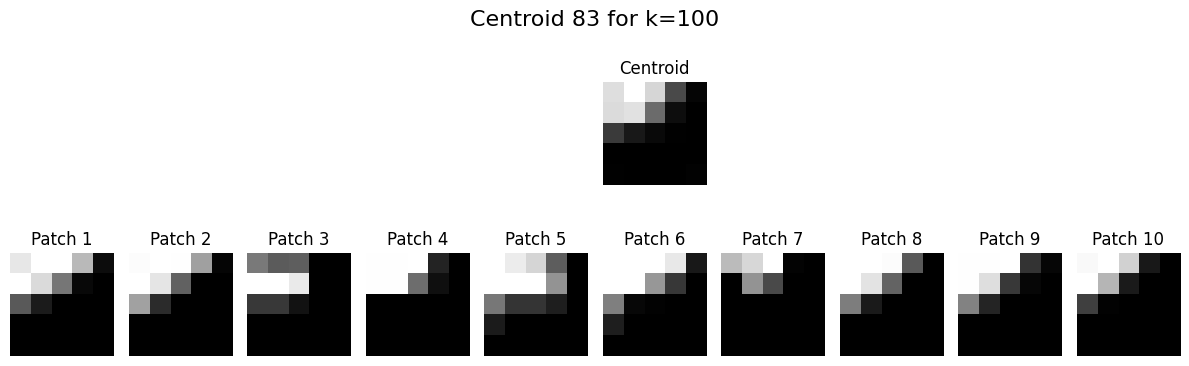

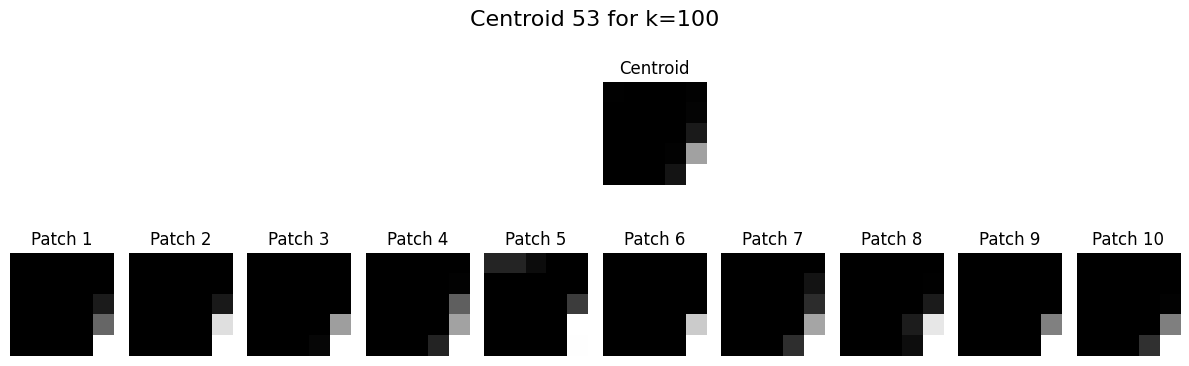

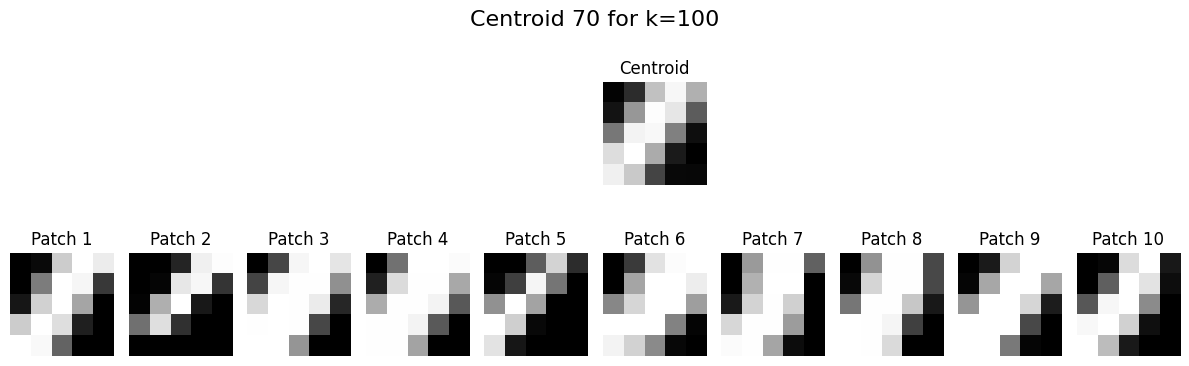

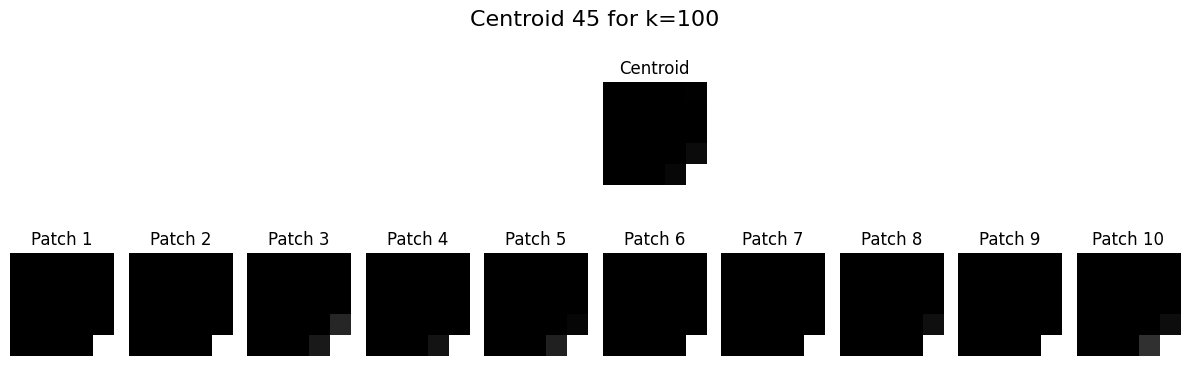

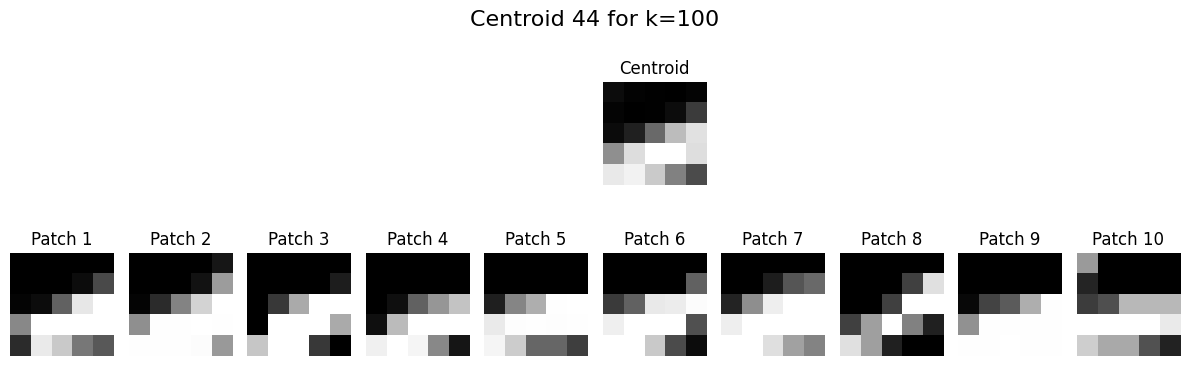

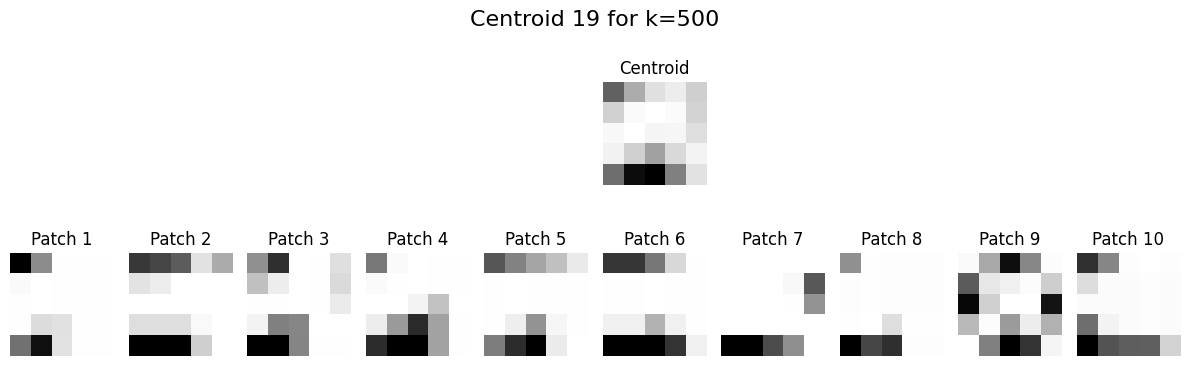

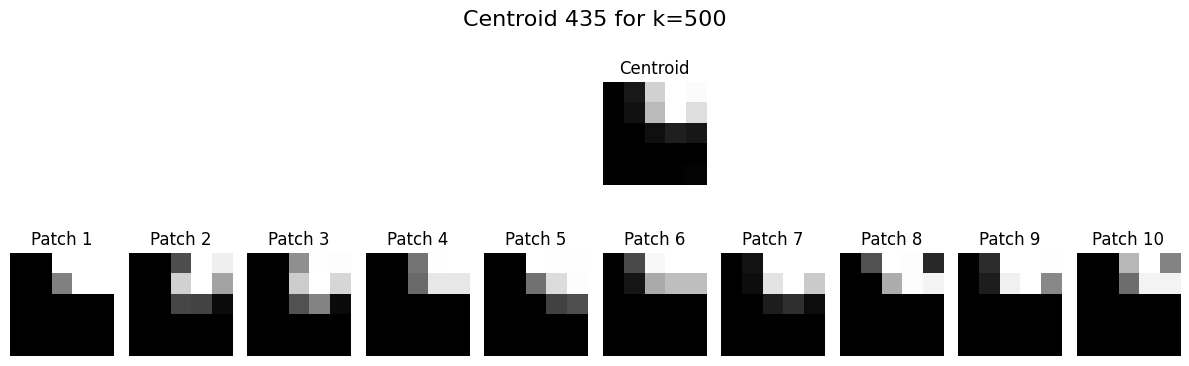

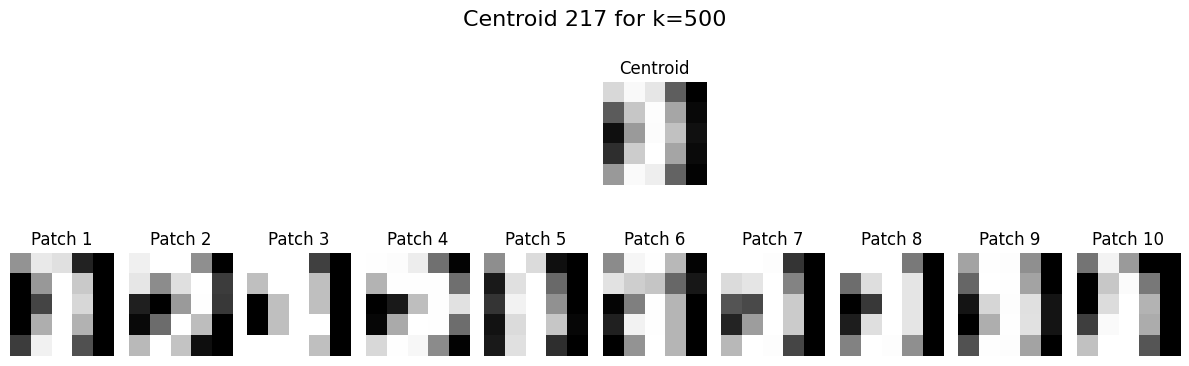

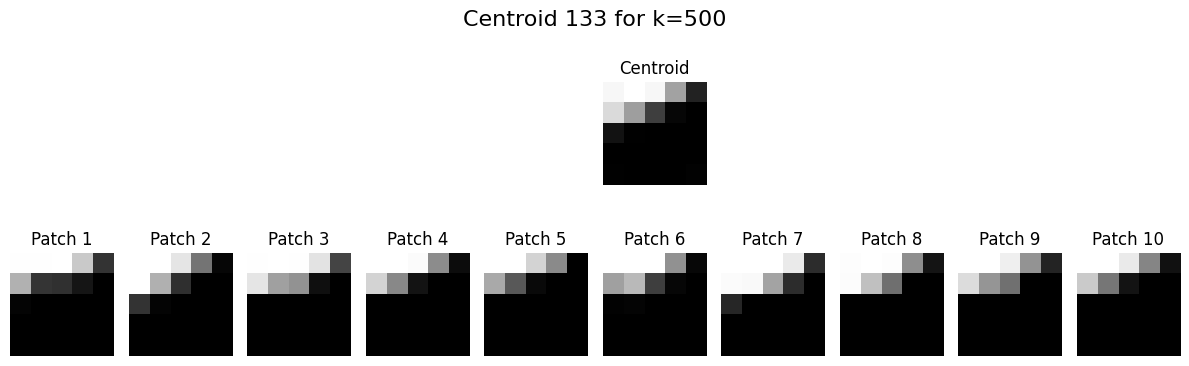

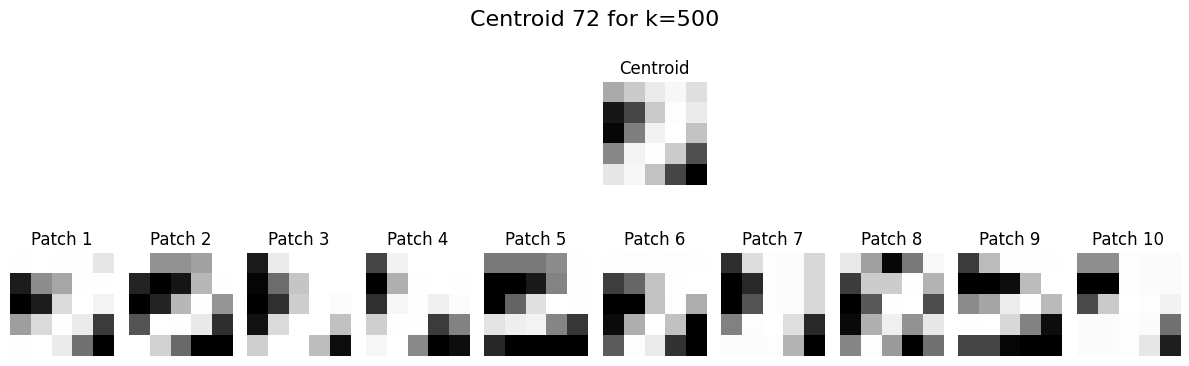

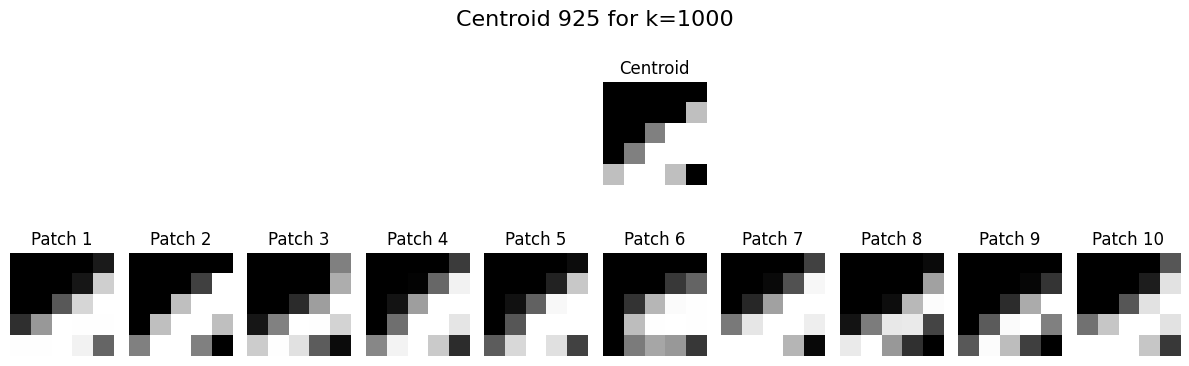

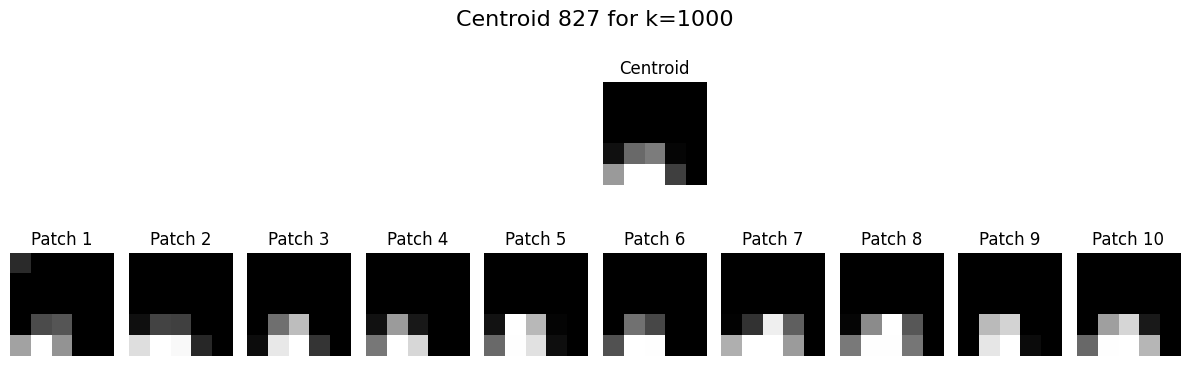

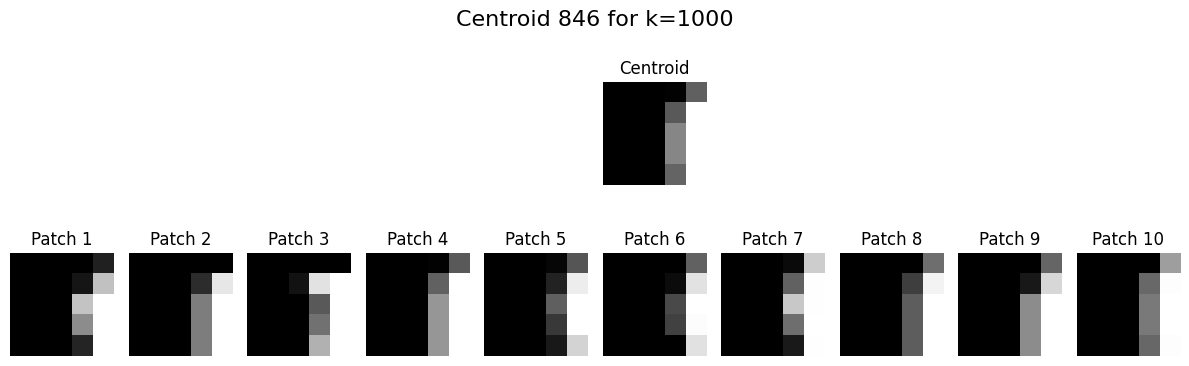

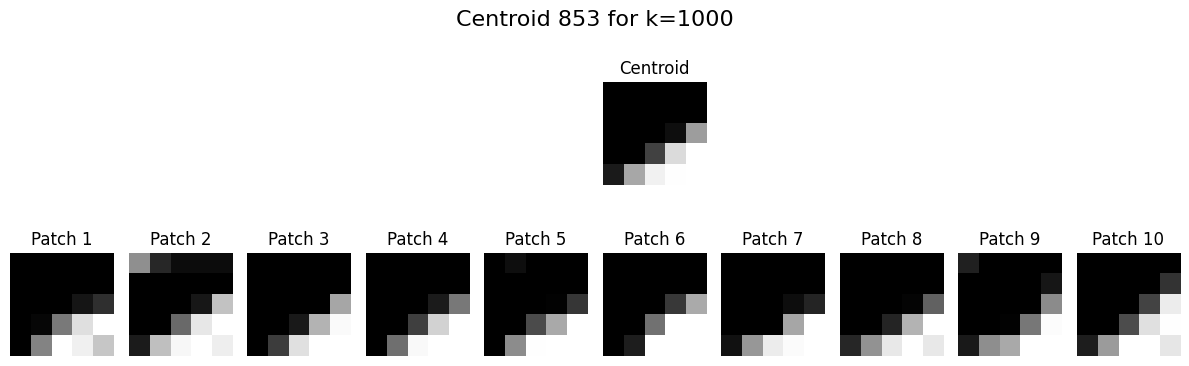

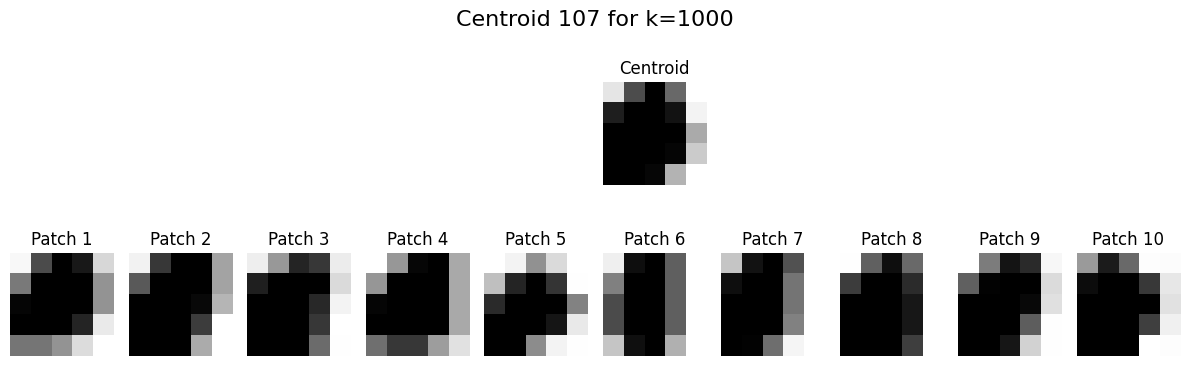

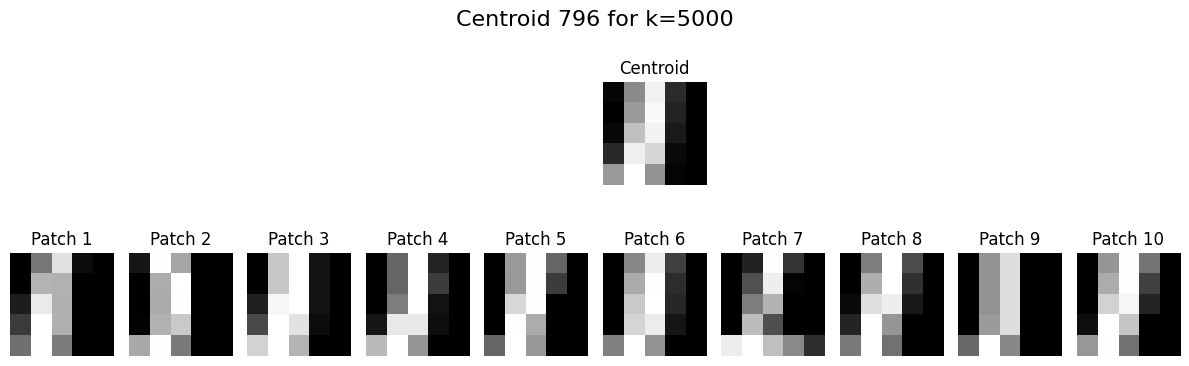

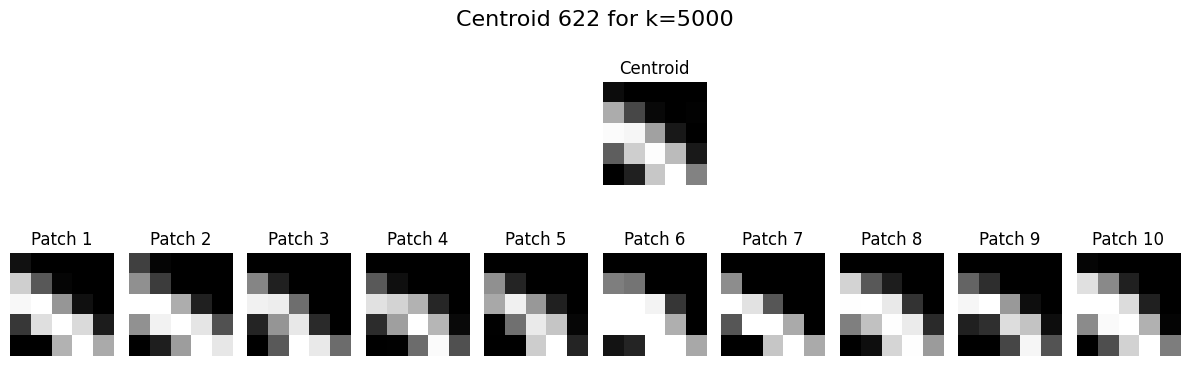

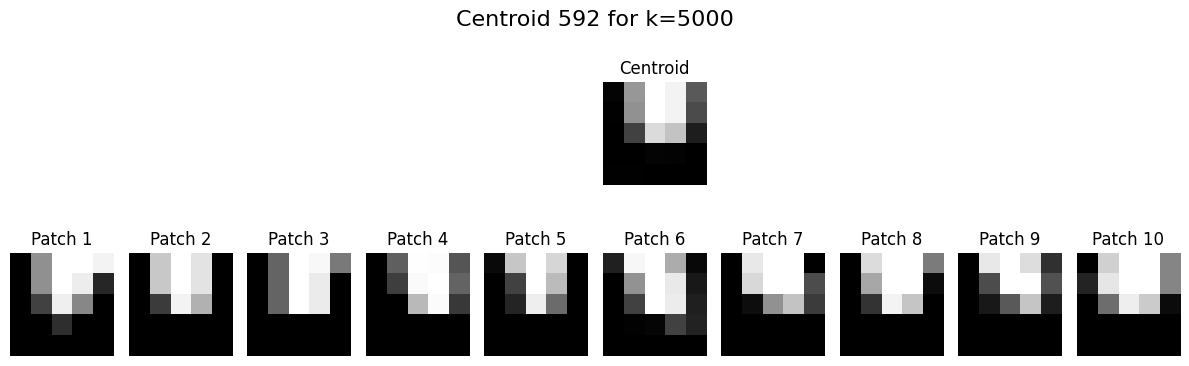

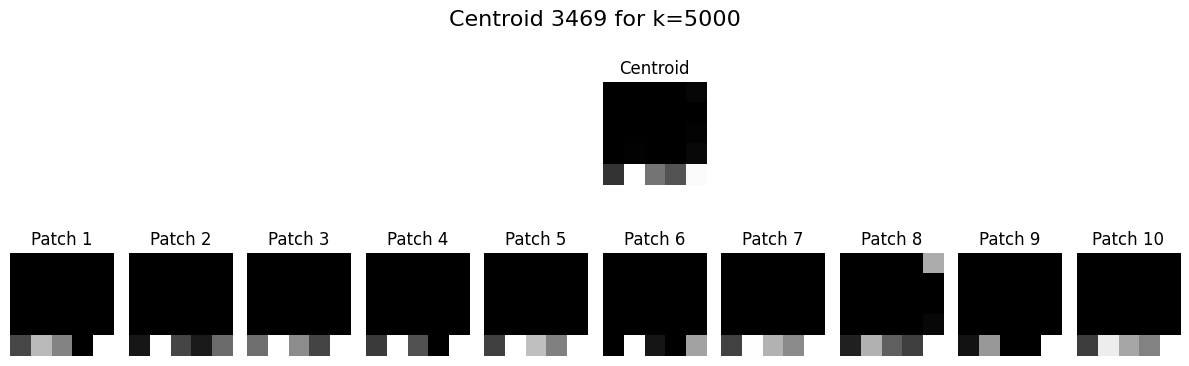

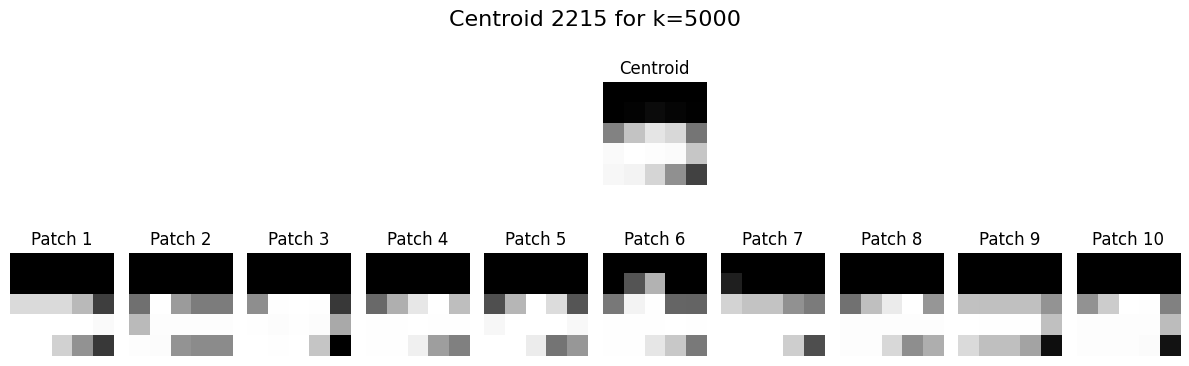

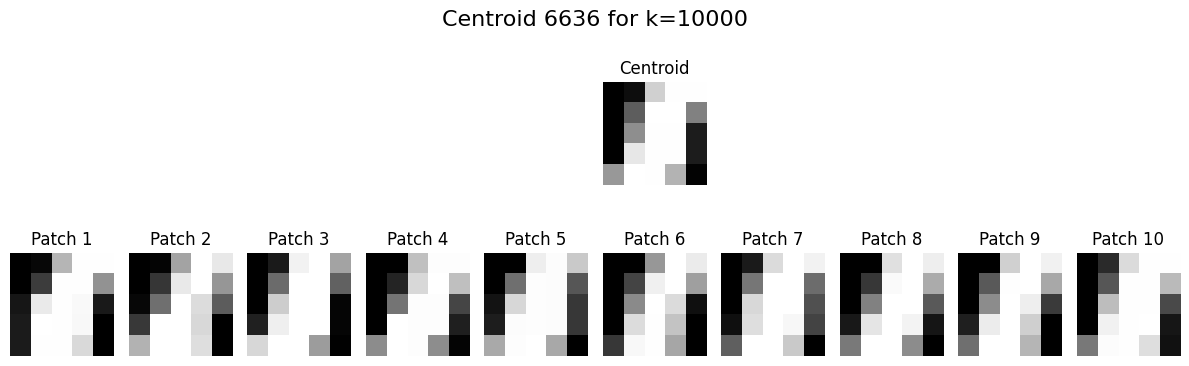

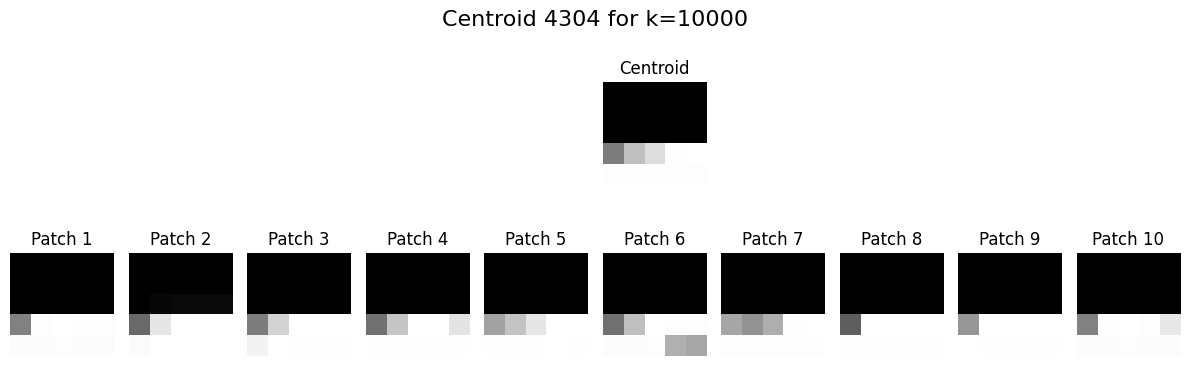

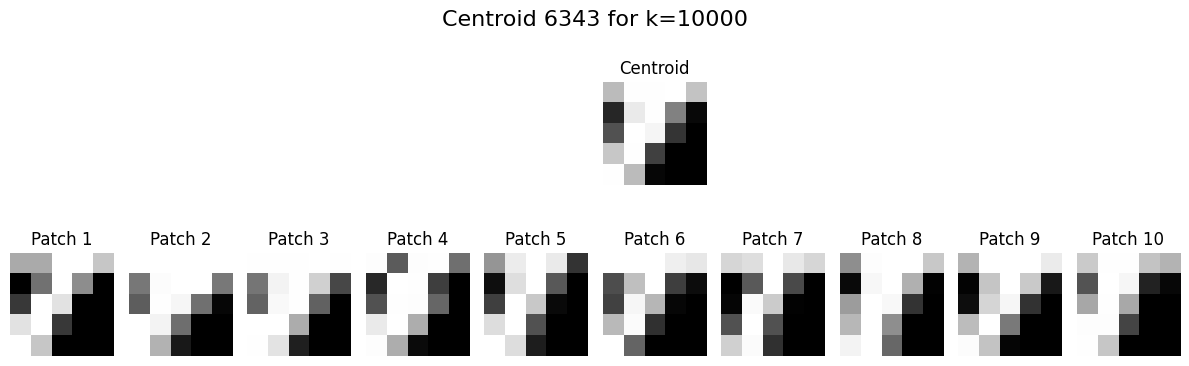

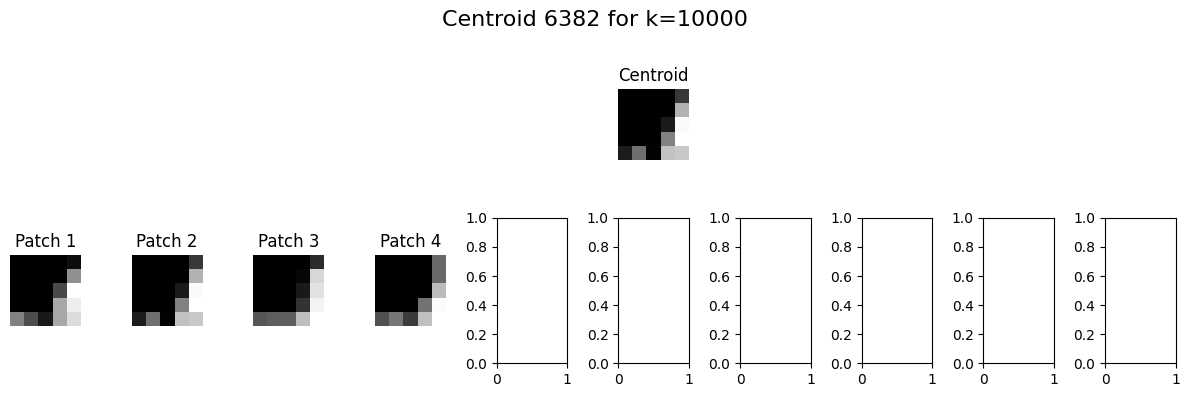

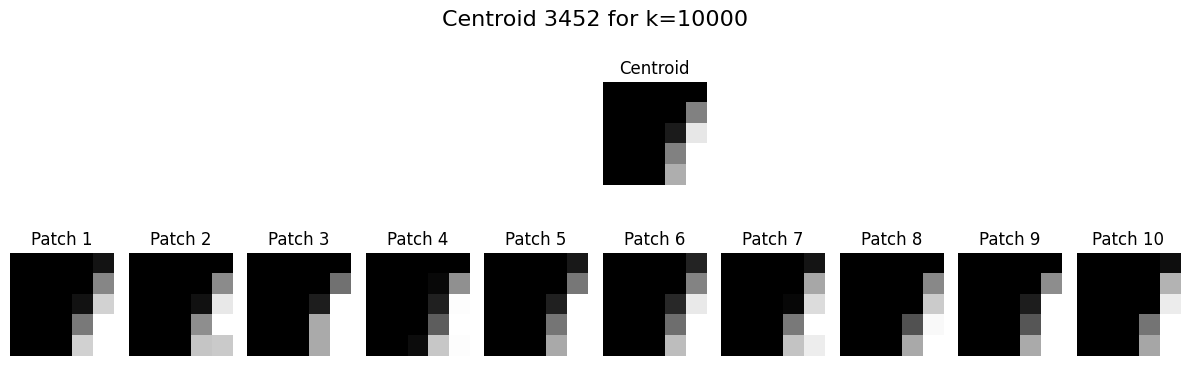

In [14]:
sample_and_plot_centroids(models, patches, k_values)


In [15]:
import matplotlib.pyplot as plt
import numpy as np

def plot_centroid(models, k, centroid_idx):
    """Plot a single centroid based on the k-value and centroid index."""
    kmeans = models[k]
    centroid = kmeans.cluster_centers_[centroid_idx].reshape(5, 5)

    plt.figure(figsize=(2, 2))
    plt.imshow(centroid, cmap='gray', interpolation='nearest')
    plt.title(f'Centroid {centroid_idx} for k={k}')
    plt.axis('off')
    plt.show()


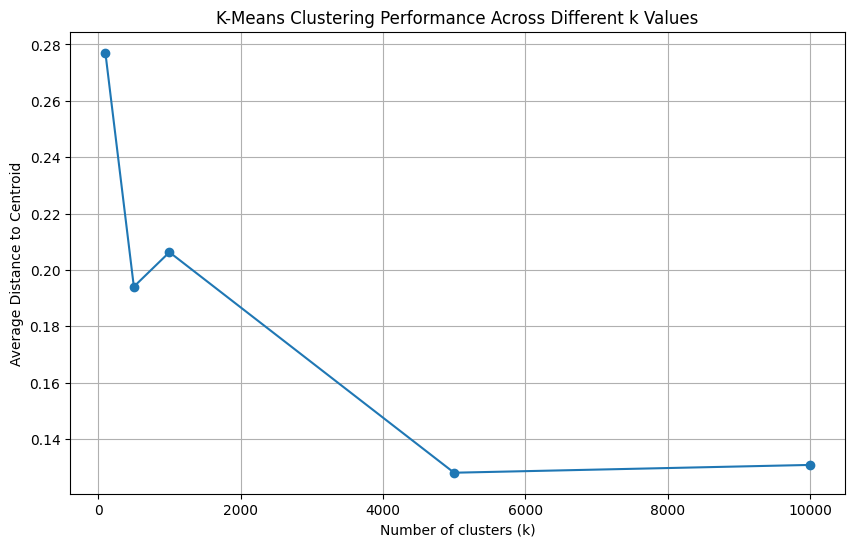

In [6]:
def compare_k_means_performance(models, data):
    avg_distances = []
    k_values = sorted(models.keys())

    for k in k_values:
        kmeans = models[k]
        centroids = kmeans.cluster_centers_
        labels = kmeans.labels_
        distances = np.linalg.norm(data - centroids[labels], axis=1) #euclidean distance  
        avg_distance = np.mean(distances)
        avg_distances.append(avg_distance)

    plt.figure(figsize=(10, 6))
    plt.plot(k_values, avg_distances, marker='o')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Average Distance to Centroid')
    plt.title('K-Means Clustering Performance Across Different k Values')
    plt.grid(True)
    plt.show()

# Example usage
compare_k_means_performance(models, patches)

In [6]:
def plot_centroids_around_index(models, k, centroid_idx, radius=5):
    """Plot a selected centroid and additional centroids around it for a given k."""
    kmeans = models[k]
    centroids = kmeans.cluster_centers_
    num_centroids = len(centroids)

    # Calculate the range of indices to plot
    start_idx = max(0, centroid_idx - radius)
    end_idx = min(num_centroids, centroid_idx + radius + 1)

    cols = end_idx - start_idx  # Number of columns in the subplot
    fig, axes = plt.subplots(1, cols, figsize=(2 * cols, 2))
    
    for i, idx in enumerate(range(start_idx, end_idx)):
        ax = axes[i]
        centroid = centroids[idx].reshape(5, 5)
        ax.imshow(centroid, cmap='gray', interpolation='nearest')
        ax.set_title(f'Centroid {idx}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Example usage
# Assuming 'models' is your dictionary of trained MiniBatchKMeans models
# Specify 'k', the centroid index you're interested in, and 'radius' of indices around it


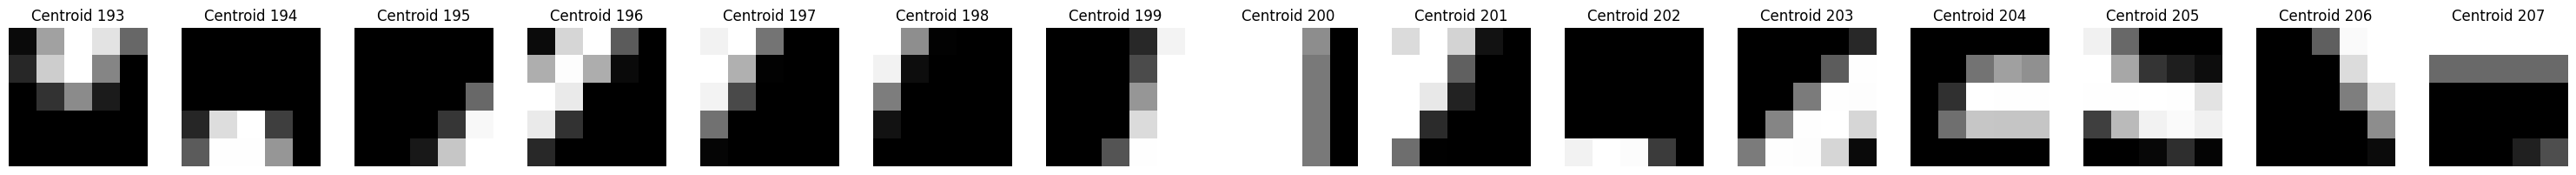

In [7]:
idx = 200
plot_centroids_around_index(models, 10000, idx, radius=7)

In [8]:
def calculate_pairwise_distances(centroids):
    """Calculate the pairwise Euclidean distances between all centroids."""
    distances = np.linalg.norm(centroids[:, np.newaxis] - centroids[np.newaxis, :], axis=2)
    return distances


In [9]:
def find_nearest_centroids(distances, centroid_index, n_neighbors=5):
    """Find the nearest 'n_neighbors' centroids to a given centroid index."""
    # Get all distances for the specified centroid and sort them
    sorted_indices = np.argsort(distances[centroid_index])
    
    # Return the indices of the closest centroids, excluding the centroid itself (first index)
    return sorted_indices[1:n_neighbors+1]


In [9]:
# Assuming 'models' is your dictionary of trained MiniBatchKMeans models
from scipy.spatial import distance
import joblib
import numpy as np
import matplotlib.pyplot as plt

def precompute_distances_scipy(models, k):
    centroids = models[k].cluster_centers_
    # Compute pairwise distances
    dist_array = distance.pdist(centroids, 'euclidean')
    distances = distance.squareform(dist_array)
    # Save the computed distances
    joblib.dump(distances, f'centroids_distances_k_{k}.pkl')

def load_precomputed_distances(k):
    # Load the precomputed distances
    return joblib.load(f'centroids_distances_k_{k}.pkl')

def find_nearest_centroids(distances, centroid_index, n_neighbors=5):
    """Find the indices of the nearest neighbors to a given centroid."""
    # Retrieve all distances for the specified centroid
    centroid_distances = distances[centroid_index]

    # Get indices of the closest centroids, excluding the centroid itself
    # Argsort sorts in ascending order; the first index will be the centroid itself with distance 0
    nearest_indices = np.argsort(centroid_distances)[1:n_neighbors + 1]

    return nearest_indices


def plot_centroid_and_neighbors_precomputed(distances, centroids, centroid_index, n_neighbors=5):
    nearest_indices = find_nearest_centroids(distances, centroid_index, n_neighbors)
    
    # Plotting
    fig, axes = plt.subplots(1, n_neighbors + 1, figsize=(2 * (n_neighbors + 1), 2))
    axes[0].imshow(centroids[centroid_index].reshape(5, 5), cmap='gray')
    axes[0].set_title(f'Centroid {centroid_index}')
    axes[0].axis('off')

    for i, idx in enumerate(nearest_indices, start=1):
        axes[i].imshow(centroids[idx].reshape(5, 5), cmap='gray')
        axes[i].set_title(f'Centroid {idx}')
        axes[i].axis('off')

    plt.suptitle(f'Centroid {centroid_index} and Its Nearest Neighbors')
    plt.tight_layout()
    plt.show()

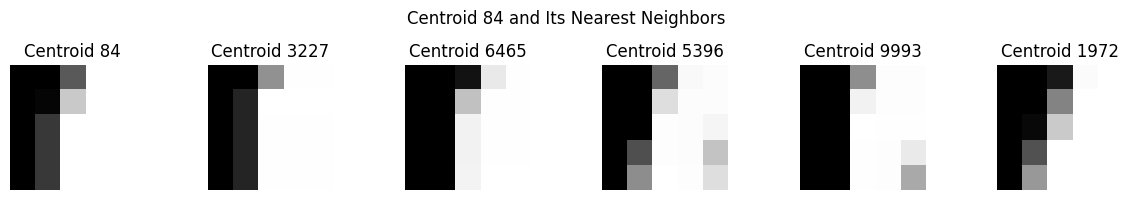

In [13]:
k = 10000
precompute_distances_scipy(models, k)  # Do this once
distances = load_precomputed_distances(k)  # Load whenever needed
centroids = models[k].cluster_centers_
plot_centroid_and_neighbors_precomputed(distances, centroids, 84, n_neighbors=5)
